# INTRO
During geospatial experiments, I found that my wasserstein distances were consistently higher than my computed vineyard distances. I looked into the vineyard distance calculations and found that **vineyard distance decreased as t (time step of homotopy) increased.** 

**Overall**: I fixed the problem when I removed the *dt term in the vineyard distance calculation. Mathematically, we no longer multiply the length of a vine segment by dt in the homotopy. As a result, our vineyard distances converge as t increases and our vineyard distances are all higher than W-infinity distances. See code below for a walkthrough :)

### loading data and old vdist function

In [22]:
# For Matrix Operations
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

# For Plotting
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go

# For TDA
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

X, y = fetch_openml('Mnist_784', version = 1, return_X_y = True, as_frame = False)
X = X.reshape(X.shape[0],28,28)


In [23]:
def persistence(array, dimension=None):
  height, width = array.shape
  cubeComplex = gudhi.CubicalComplex(
      dimensions = [width,height],
      top_dimensional_cells = 255 - array.flatten()
  )
 
  if dimension == None:
    persistence = cubeComplex.persistence()
    return persistence
  else:
    cubeComplex.compute_persistence()
    persistence = cubeComplex.persistence_intervals_in_dimension(dimension)
    try:
        mx = np.max(persistence[np.isfinite(persistence)])
        persistence[np.isinf(persistence)] = mx

    except:
        persistence[np.isinf(persistence)] = 255 
    return persistence
def Get_Vinyard(f, g, D, t = 101):
##########
    # input:
        # f and g by which you want to interpolate using straight line homotopy
        # the dimension of persistence you want
    # output:
        # series of persistence diagrams: hs
        # persistence vinyard polotted in 3d space: res
        # death value of largest persistence: mx

##########


    # creates equal intervals from 0 to 100
    ts = np.linspace(0,1,t)
    # creates homology from f to g using these intervals
    hs = np.array([(t * f) + (1-t) * g for t in ts])
    
    PDD = [persistence(h,dimension = D) for h in hs]

# tracking each vine. the third entry tracks what vine is matche dup to what wasserstein point
    # vines[0] is birth frame
    # vines[1] is death frame
    # vines[2] keeps track of what point the vine is in the corresponding persistence diagram
    vines = [[0, None, [x,]] for x in range(len(PDD[0]))]
    # each vine is matched to itself in the ends matrix
    ends = {x:x for x in range(len(PDD[0]))}

    for i in range(1, len(ts)):
        dist, match = gudhi.hera.wasserstein_distance(PDD[i-1], PDD[i], matching = True)

        baby = [] 

        new_ends = {k:ends[k] for k in ends}
        for j, (x,y) in enumerate(match):
            if x == -1:
                baby.append(j)
            elif y == -1:
                # ends the vine
                
                # we record death frame
                vines[ends[x]][1] = i
                # -1 tells us the vine is dead in our PD
                vines[ends[x]][2].append(-1)
            else:
                # updating vines. Adding the match to our vines matrix
                vines[ends[x]][2].append(y)
                # setting ends to new_ends for the next iteration
                new_ends[y] = ends[x] 

        for j in baby:
            x, y = match[j]
            new_ends[y] = len(vines)
            vines.append([i, None, [y,]])
            # print(f"new {y} -> *")

        for k in [l for l in ends]: 
            if k >= len(PDD[i]):
                del new_ends[k]

        ends = new_ends


    # this block takes the tracking in vines[i][2] and replaces it with the numpy array of the vines birth and death times.
    # these times are taken at each time step of our vinyard
    # for example: poss[1][2][3] is the birth/death times of vine number 2 at time step 4. Note that indices are 1 less than their frame #
    poss = vines
    for i,_ in enumerate(vines):
        repl = []
        for j,x in enumerate(vines[i][2]):
            # if vine is dead at that frame
            if x == -1:
                repl.append(np.mean(PDD[vines[i][0]+j-1][vines[i][2][j-1]])*np.ones((2,))) # proj prev
            else:
                repl.append(PDD[vines[i][0]+j][x])
        poss[i][2] = np.array(repl)




    # these are the vine values in 3d space

    # we iterate through each vine, to create a res entry (res[0] corresponds to vine zero)
    # res[0][b(t) -> d(t)] is a triple list consisting of:
        # [time value, birth time, death time]

    res = [[[ts[p[0]+np.arange(len(p[2]))][i], *x] for i,x in enumerate(p[2])] for p in poss]

    mx = 'hey'
    #mx = np.max([np.max(p[2]) for p in poss if np.inf not in p[2]])
    # getting the max death time of all the vines

    return res, mx, hs
def Plot_Vinyard(res, mx, hs):


    gos = []

    # x axis is time
    # y axis is birth time
    # z axis is death time
    for vine in res:
        vine = np.array(vine)

        gos.append(go.Scatter3d(x=vine[:,0], y=vine[:,1], z=vine[:,2], marker=dict(
            size=2,
        ),
        line=dict(
            width=2
        )))


    xs = np.linspace(0, mx, 10)
    zs = np.linspace(0, 1, 10)
    xss, zss = np.meshgrid(xs, zs)
    gos.append(go.Surface(x=zss, y=xss, z=xss, colorscale=[[0, '#333'], [1, '#333']], opacity=0.1, showscale=False)) # x - y = 0: diag plane
    fig = go.Figure(data=gos)

    fig.update_layout(
        width=800,
        height=700,
        scene=dict(
        xaxis_title='T (homotopy)',
        yaxis_title='Birth',
        zaxis_title='Death'
    )
    )

    fig.show()
def vdist(res, f, g): # diag weight func, length weight func
    V = 0
    for vine in res:
        vine = np.array(vine)
        v, L = 0, 0
        for i in range(1, len(vine)):
            l = np.linalg.norm(vine[i][1:]-vine[i-1][1:], ord = np.inf)
            dt = vine[i][0] - vine[i-1][0]

            mid = np.mean([vine[i][1:],vine[i-1][1:]], axis=0)
            proj = np.mean(mid)*np.ones(2,)
            # this is the persistence of the mid point distance traveled
            D = np.linalg.norm(proj-mid, ord = np.inf)

            v += f(D)*l * dt
            L += l * dt

        v *= g(L)
        V += v

    return V
def fD(D):
    return D/100
def fL(L):
    return 1
def Test_Mnist(N1, N2, dimension = 1, no_samples = 100, t = 25):

    # fetching Mnist, finding a three and a eight. Creating an f and g for our test:

    X, y = fetch_openml('Mnist_784', version = 1, return_X_y = True, as_frame = False)
    # X is 70000 images, y is the classifications
    X.shape
    # taking each image and turning it into a 3d array. Each slide is a 28 by 28 grayscale grid

    X = X.reshape(X.shape[0],28,28)

    # finding all the 6's and 9's and filtering them out
    f = X[np.where(y == str(N1))]
    g = X[np.where(y == str(N2))]


    if no_samples > len(f) or no_samples >len(g):
        no_samples = max(len(f), len(g))
    f = f[:no_samples]
    g = g[:no_samples]

    Combined_Array = np.concatenate((f, g), axis = 0)

    # Distances Calculations
    Vinyard_Distances = np.zeros((Combined_Array.shape[0], Combined_Array.shape[0]))

    for i in range(Combined_Array.shape[0]):
        for j in range(i+1,Combined_Array.shape[0]):
            Vinyard_Distances[i,j] = vdist(Get_Vinyard(Combined_Array[i], Combined_Array[j],dimension, t)[0],fD,fL)
    Vinyard_Distances += np.transpose(Vinyard_Distances)

    # MDS Embedding
    Vinyard_MDS_Embedding = MDS(n_components = 2, metric = True, dissimilarity = 'precomputed', random_state = 32).fit_transform(Vinyard_Distances)


    # Plotting
    fig, ax = plt.subplots()

    # Red is N1 and Blue is N2
    scatter = ax.scatter(Vinyard_MDS_Embedding[:, 0], Vinyard_MDS_Embedding[:, 1], c = ['red'] * no_samples + ['blue'] * no_samples, s=10)


    plt.title('Vinyard MDS')
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    #plt.show()
    return Vinyard_Distances


### Problem:
When I was performing analysis on demographic data, I found that my vdist was consistently lower than my wasserstein distance. This runs contrary to the bounds Alvan and Thomas proved. 

The problem lies in how we are factoring in dt with our straight line homotopy. **Vinyard Distance decreases as the time step of our homotopy increases**. Also note that the MDS embedding changes when t = 1000.

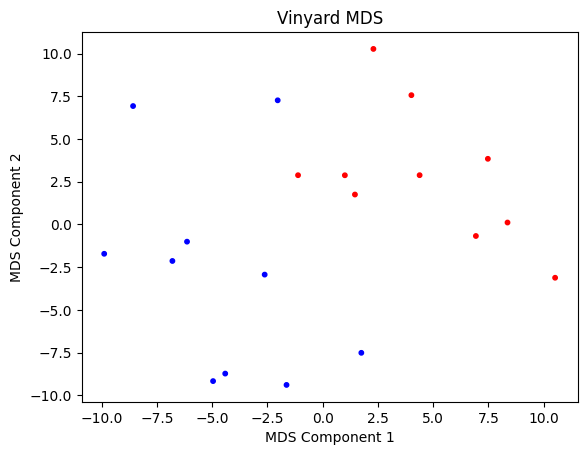

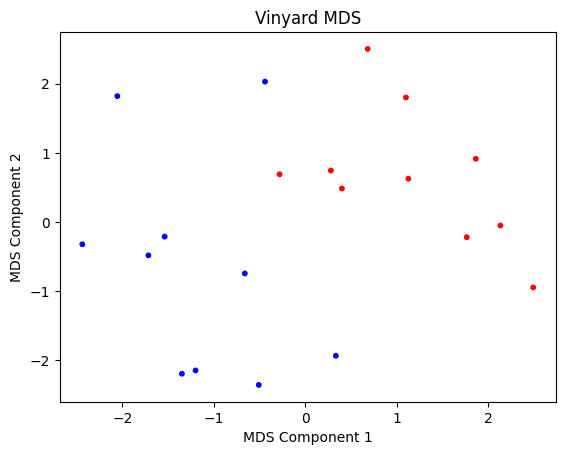

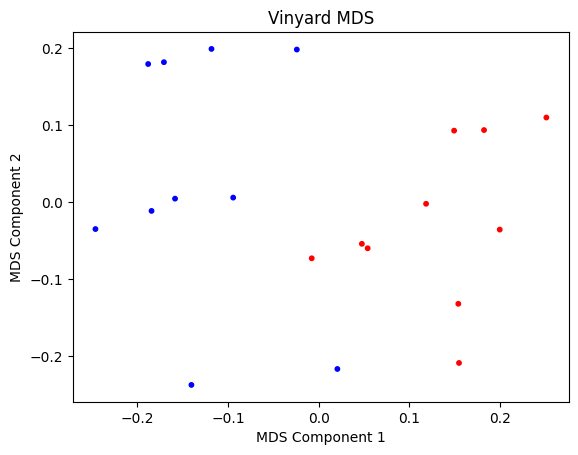

In [24]:
# vineyard distance matrix with time step 25
t_25 = Test_Mnist(6,9,dimension = 1, no_samples = 10, t = 25)
# vineyard distance matix with time step 100
t_100 = Test_Mnist(6,9,dimension = 1, no_samples = 10, t = 100)
# vineyard distance matrix with time step 1000
t_1000 = Test_Mnist(6,9,dimension = 1, no_samples = 10, t = 1000)


In [25]:
print(t_100 - t_25)
# all values are negative. distances are smaller in t_100 than in t_25
print(t_1000 - t_100)
# all values are negative. distances are smaller in t_1000 than in t_1000

[[  0.          -6.66338497  -4.36726081  -8.64849188  -6.54880646
   -7.61858735  -9.67457753  -2.59618131  -6.19501029  -4.46025534
  -10.78989294  -9.35227646 -10.37060061 -12.20496941 -10.10319531
  -12.74251545 -12.47032872  -8.62833365 -11.73416933  -9.35037952]
 [ -6.66338497   0.          -1.5406238   -4.41376448  -4.94597974
   -5.63111102  -5.28529213  -5.25200538  -8.08401119  -3.69982026
  -10.43001239  -6.4263791   -7.2084717   -9.25041478  -7.15578657
   -9.05144104  -6.4301598   -6.14661268  -8.18786798  -3.69244919]
 [ -4.36726081  -1.5406238    0.          -3.76819133  -4.52750959
   -6.03114135  -7.95781127  -4.67525004  -7.00739822  -4.99976643
   -9.0395976   -6.22006331  -7.89958233  -9.29065368  -6.76615019
   -9.70599312  -7.47587123  -6.18751423  -8.82372183  -2.61286449]
 [ -8.64849188  -4.41376448  -3.76819133   0.          -6.14869337
   -3.60331925  -5.90397801  -7.98855484  -9.46307647  -3.7414161
   -9.77327166  -6.30191471  -7.99097674  -8.80449483  -7.64

Our vineyard however, look the same. There is little to no change in the vines as we increase t. 

we can confirm this visually:

In [26]:
f = X[np.where(y == '6')]
g = X[np.where(y == '9')]

# vineyard for time step 25
Plot_Vinyard(Get_Vinyard(f[0],g[0],D = 1, t = 25)[0], 255, hs = None)
# vineyard for time step 100
Plot_Vinyard(Get_Vinyard(f[0],g[0],D = 1, t = 100)[0], 255, hs = None)
# vineyard for time step 1000
Plot_Vinyard(Get_Vinyard(f[0],g[0],D = 1, t = 1000)[0], 255, hs = None)


we can also look at the first vine of each of these vineyards. Since the underlying data is the same, the vine converges to the same start and death point as t increases.

In [27]:
vine_0_25 = (Get_Vinyard(f[0],g[0],D = 1, t = 25)[0])[0]
vine_0_100 = (Get_Vinyard(f[0],g[0],D = 1, t = 100)[0])[0]
vine_0_1000 = (Get_Vinyard(f[0],g[0],D = 1, t = 1000)[0])[0]
vine_0_10000 = (Get_Vinyard(f[0],g[0],D = 1, t = 10000)[0])[0]

print('t = 25:')
print(f'start: {vine_0_25[0]}')
print(f'end: {vine_0_25[-1]}')
print('\n')

print('t = 100:')
print(f'start: {vine_0_100[0]}')
print(f'end: {vine_0_100[-1]}')
print('\n')

print('t = 1000:')
vine_0_1000 = (Get_Vinyard(f[0],g[0],D = 1, t = 1000)[0])[0]
print(f'start: {vine_0_1000[0]}')
print(f'end: {vine_0_1000[-1]}')
print('\n')

print('t = 10000:')
vine_0_10000 = (Get_Vinyard(f[0],g[0],D = 1, t = 10000)[0])[0]
print(f'start: {vine_0_10000[0]}')
print(f'end: {vine_0_10000[-1]}')



t = 25:
start: [0.0, 213.0, 231.0]
end: [0.16666666666666666, 198.0625, 198.0625]


t = 100:
start: [0.0, 213.0, 231.0]
end: [0.22222222222222224, 181.37878787878788, 181.37878787878788]


t = 1000:
start: [0.0, 213.0, 231.0]
end: [0.24424424424424424, 175.4189189189189, 175.4189189189189]


t = 10000:
start: [0.0, 213.0, 231.0]
end: [0.24632463246324635, 174.84798479847984, 174.84798479847984]


However their distances are still not equal. But we can see they are decreasing by a factor of 10. **This is beacuse I am increasing homotopy by a factor of 10**

In [28]:
print('t = 25')
print(vdist([vine_0_25], fD, fL))
print('\n')

print('t = 100:')
print(vdist([vine_0_100], fD, fL))
print('\n')

print('t = 1000:')
print(vdist([vine_0_1000], fD, fL))
print('\n')

print('t = 10000:')
print(vdist([vine_0_10000], fD, fL))



t = 25
0.08388753255208334


t = 100:
0.025135109126155998


t = 1000:
0.002532006988727223


t = 10000:
0.0002530111726016987


Our W-inf distances are also larger:

In [29]:
def Get_W_Infinity(PD1, PD2):
    x, matches = gudhi.hera.wasserstein_distance(PD1,PD2, matching = True)
    # resetting distances
    dist = []
    for match in matches:
        if match[0] == -1:
            # if the first index of the match is -1, we match the point in PD2 to the diagonal
            dist.append(np.abs((PD2[match[1]][0] - PD2[match[1]][1])/2))
        elif match[1] == -1:
            # if the second index of the match is -1, we match the point in PD1 to the diagonal
            dist.append(np.abs((PD1[match[0]][0] - PD1[match[0]][1])/2))
        else:
            # if neighter are -1, we take the absolute value of the difference between their births's and deaths's
            dist.append(np.max([np.abs((PD1[match[0]][0] - PD2[match[1]][0])),
                              np.abs((PD1[match[0]][1] - PD2[match[1]][1]))]    
                              ))

    # checking that I did distances right:
    # distance computed by gudhi - distance computed by me:
    # print(x - np.sum(dist))

    return np.max(dist)

def Get_W_Distance(f,g,no_samples = 10, D = 1):
    f_PDD = [persistence(img, 1) for img in f[:no_samples]]
    g_PDD = [persistence(img, 1) for img in g[:no_samples]]

    f_PDD.extend(g_PDD)
    # creates equal intervals from 0 to 100
    W_Dist = np.zeros((len(f_PDD), len(f_PDD)))
    
    for i in range(W_Dist.shape[0]):
        for j in range(W_Dist.shape[1]):
            if j > i:
                W_Dist[i][j] = Get_W_Infinity(f_PDD[i],f_PDD[j])
    return W_Dist + W_Dist.transpose()
W =  Get_W_Distance(f, g, no_samples = 10, D = 1)
print(np.where(W>t_25))
print(np.where(W>t_100))
print(np.where(W>t_1000))


(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 1

However, if I change the vdist function to remove the (*dt) term. we see that the vineyard distances converge.

In [30]:
def vdist(res, f, g): # diag weight func, length weight func
    V = 0
    for vine in res:
        vine = np.array(vine)
        v, L = 0, 0
        for i in range(1, len(vine)):
            l = np.linalg.norm(vine[i][1:]-vine[i-1][1:])
            dt = vine[i][0] - vine[i-1][0]

            mid = np.mean([vine[i][1:],vine[i-1][1:]], axis=0)
            proj = np.mean(mid)*np.ones(2,)
            # this is the persistence of the mid point distance traveled
            D = np.linalg.norm(proj-mid)
            # removed * dt
            v += f(D)*l 
            L += l 

        v *= g(L)
        V += v

    return V


print('t = 25')
print(vdist([vine_0_25], fD, fL))
print('\n')

print('t = 100:')
print(vdist([vine_0_100], fD, fL))
print('\n')

print('t = 1000:')
print(vdist([vine_0_1000], fD, fL))
print('\n')

print('t = 10000:')
print(vdist([vine_0_10000], fD, fL))


t = 25
3.471421655808905


t = 100:
4.257577434045394


t = 1000:
4.325588495348847


t = 10000:
4.326223498210229


Additionally, the Wasserstein distances are all less than the vineyard distance. This fixes the lower bound issue I found in my geospatial experiments. Note that our MDS is not changed.

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


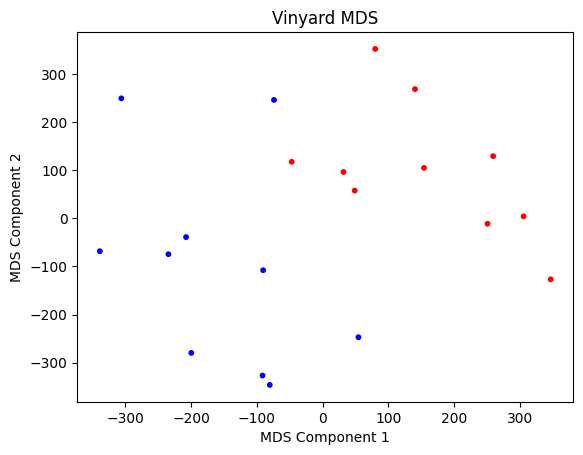

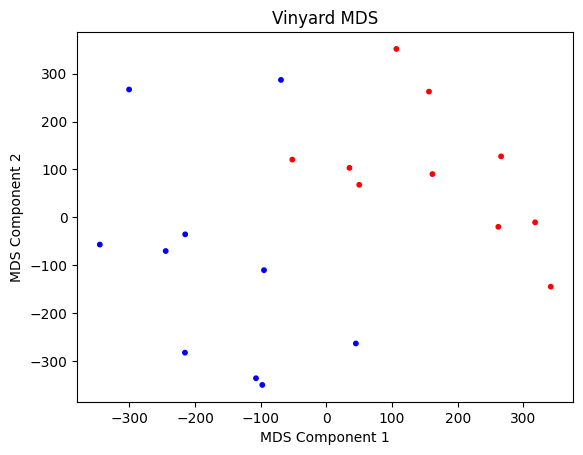

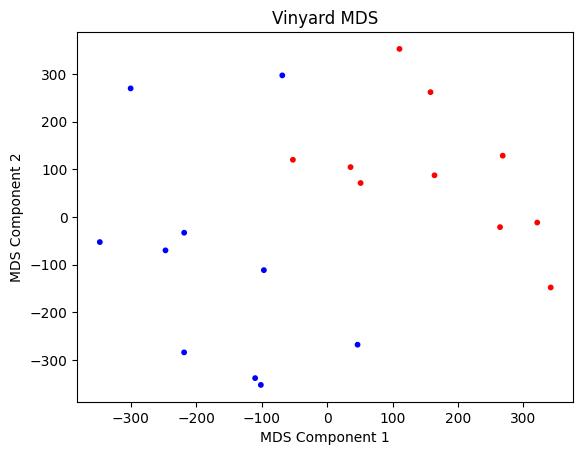

In [31]:
# vineyard distance matrix with time step 25
t_25 = Test_Mnist(6,9,dimension = 1, no_samples = 10, t = 25)
# vineyard distance matix with time step 100
t_100 = Test_Mnist(6,9,dimension = 1, no_samples = 10, t = 100)
# vineyard distance matrix with time step 1000
t_1000 = Test_Mnist(6,9,dimension = 1, no_samples = 10, t = 1000)
W =  Get_W_Distance(f, g, no_samples = 10, D = 1)
print(np.where(W>t_25))
print(np.where(W>t_100))
print(np.where(W>t_1000))